# CNTK 205 Artistic Style Transfer

This tutorial shows how to transfer the style of one image to another. This allows us to take our ordinary photos and render them in the style of famous images or paintings.

Apart from creating nice looking pictures, in this tutorial you will learn how to load a pretrained VGG model into CNTK, how to get the gradient of a function with respect to an input variable (rather than a parameter), and how to use the gradient outside of CNTK.

We will follow the approach of [Gatys et. al.](https://arxiv.org/abs/1508.06576) with some of the improvements in [Novak and Nikulin](https://arxiv.org/abs/1605.04603). While [faster techniques](https://arxiv.org/abs/1603.08155) exist, these are limited to transfering a particular style.

We begin by importing the necessary packages. In addition to the usual suspects (`numpy`, `scipy`, and `cntk`) we will need `PIL` to work with images, `requests` to download a pretrained model and h5py to read in the weights of the pretrained model.

In [1]:
import numpy as np
from scipy import optimize as opt
import cntk as C
from PIL import Image
import requests
import h5py
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt

### Setting up the network
The pretrained model is a VGG network which we got from [this page](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3). Below we download it if it is not already available locally and load the weights into numpy arrays.

In [2]:
def download(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, "wb") as handle:
        for data in response.iter_content(chunk_size=2**20):
            if data: handle.write(data)

def load_model(path):
    f = h5py.File(path)
    layers = dict()
    for k in range(f.attrs['nb_layers']):
        g = f['layer_{}'.format(k)]
        layers[k] = [g['param_{}'.format(p)][:] for p in range(g.attrs['nb_params'])]
    f.close()
    return layers

path = "vgg16_weights.bin"
url = "https://cntk.ai/jup/models/vgg16_weights.bin"
if not os.path.exists(path):
    print("downloading VGG model (~0.5GB)")
    download(url, path)
layers = load_model(path)
print("loaded VGG model")

downloading VGG model (~0.5GB)
loaded VGG model


Next we define the VGG network as a CNTK graph. 

In [3]:
def vggblock(x,lin,lout,name):
    f = lin[0]
    b = lin[1]
    k = C.constant(value = f)
    t = C.constant(value = np.reshape(b, (-1, 1, 1)))
    y = C.relu(C.convolution(k, x, auto_padding = [True, True, False]) + t)
    lout[name]=y
    return y

def vggpool(x):
    y=C.pooling(x, C.AVG_POOLING, (2, 2), (2, 2))
    return y

def model(x,layers):
    model_layers = {}
    l=[layers[i] for i in range(30) if len(layers[i])==2]
    x = vggblock(x,l[0],model_layers,'conv1_1')
    x = vggblock(x,l[1],model_layers,'conv1_2')
    x = vggpool(x)
    
    x = vggblock(x,l[2],model_layers,'conv2_1')
    x = vggblock(x,l[3],model_layers,'conv2_2')
    x = vggpool(x)
    
    x = vggblock(x,l[4],model_layers,'conv3_1')
    x = vggblock(x,l[5],model_layers,'conv3_2')
    x = vggblock(x,l[6],model_layers,'conv3_3')
    x = vggpool(x)
    
    x = vggblock(x,l[7],model_layers,'conv4_1')
    x = vggblock(x,l[8],model_layers,'conv4_2')
    x = vggblock(x,l[9],model_layers,'conv4_3')
    x = vggpool(x)
    
    x = vggblock(x,l[10],model_layers,'conv5_1')
    x = vggblock(x,l[11],model_layers,'conv5_2')
    x = vggblock(x,l[12],model_layers,'conv5_3')
    x = vggpool(x)
    return x, C.combine([model_layers[k] for k in sorted(model_layers.keys())])

### Defining the loss function

The novelty in this line of work is the definition of a loss function that, when optimized, leads to a result that is close to both the content of one image, as well as the style of the other image. This loss contains multiple terms some of which are defined in terms of the VGG network we just created. Concretely, the loss takes a candidate image $x$ and takes a weighted sum of three terms: the content loss, the style loss and the total variation loss:
$$
L(x) = \alpha C(x) + \beta S(x) + T(x)
$$
where $\alpha$ and $\beta$ are weights on the content loss and the style loss respectively (we have normalized the weights so that the weight in front of the total variation loss is 1). How are each of these terms computed?

 - The total variation loss $T(x)$ is the simplest one to understand: It measures the average sum of squared differences among adjacent pixel values and encourages the result $x$ to be a smooth image. We implement this by convolving the image with a kernel containing (-1,1) both horizontally and vertically, squaring the results and computing their average.
 - The content loss is measuring the squared difference between the content image and $x$. We can measure this difference on the raw pixels or at various layers inside the VGG network. While we write the content loss as $C(x)$ it implicitly depends on the content image we provide. However since that image is fixed we do not write this dependence explicitly.
 - The style loss $S(x)$ is similar to the content loss in that it also implicitly depends on another image. The main idea of Gatys et. al. was to define the style as the correlations among the activations of the network and measure the style loss as the squared difference between these correlations. In particular for a particular layer we compute a covariance matrix among the output channels averaging across all positions. The style loss is just the squared error between the covariance matrix induced by the style image and the covariance matrix induced by $x$.
 
Below we define these loss functions

In [4]:
def flatten(x):
    assert len(x.shape) >= 3
    return C.reshape(x, (x.shape[-3], x.shape[-2] * x.shape[-1]))

def gram(x):
    features = C.minus(flatten(x), C.reduce_mean(x))
    return C.times_transpose(features, features)

def npgram(x):
    features = np.reshape(x, (-1, x.shape[-2]*x.shape[-1])) - np.mean(x)
    return features.dot(features.T)

def style_loss(a,b):
    channels, x, y = a.shape
    assert x == y
    A = gram(a)
    B = npgram(b)
    return C.squared_error(A,B)/(channels**2 * x**4)

def content_loss(a,b):
    channels, x, y = a.shape
    return C.squared_error(a,b)/(channels*x*y)

def total_variation_loss(x):
    xx = C.reshape(x, (1,)+x.shape)
    delta = np.array([-1,1],dtype=np.float32)
    kh = C.constant(value = delta.reshape(1,1,1,1,2))
    kv = C.constant(value = delta.reshape(1,1,1,2,1))
    dh = C.convolution(kh, xx, auto_padding=[False])
    dv = C.convolution(kv, xx, auto_padding=[False])
    avg = 0.5 * (C.reduce_mean(C.square(dv)) + C.reduce_mean(C.square(dh)))
    return avg

### Instantiating the loss

Now we are ready to instantiate a loss with two particular images. We will use a beautiful Seattle sunset and a painting from Leonid Afremov. We first define a few tuning parameters whose explanation is below:
 - We resize images to 200 x 200 pixels to speed up the process for ease of experimentation. You can use a larger size if you like the results.
 - The content weight and style weight are the main parameters that affect the quality of the resulting image. Typically the content weight is greater than the style weight and both are greater than the total variation weight (which is 1).
 - The decay factor is a number in (0,1) which decides how to weigh the contribution of each layer. Following [Novak and Nikulin](https://arxiv.org/abs/1605.04603) all layers contribute to both the content loss and the style loss. The content loss weighs the input more heavily and each later layer in the VGG network contributes with a weight that is exponentially smaller with its distance from the input. The style loss weighs the output of the VGG network more heavily and each earlier layer in the VGG network contributes with a weight that is exponentially smaller with its distance from the output. As in Novak and Nikulin we use a decay factor of 0.5.
 - The inner and outer parameters define how we are going to obtain our final result. We will take 10 snapshots during our search for the image that minimizes the loss. Each snapshot will be taken after 20 steps of optimization.
 - Finally a very important thing to know about our pretrained network is how it was trained. In particular, a constant vector was subtracted from all input images that contained  the average value for the red, green, and blue channels in the training set. This vector is referred to as SHIFT below.

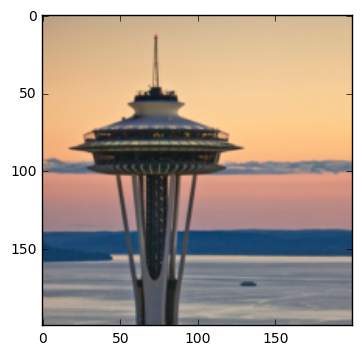

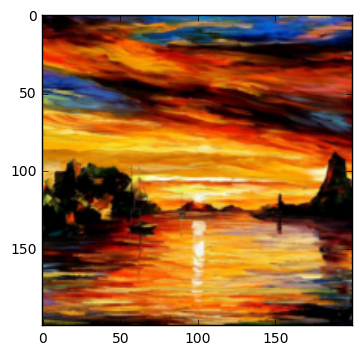

In [9]:
style_path = "afremov.jpg"
content_path = "sunset.jpg"

SIZE = 200
content_weight = 100.0
style_weight = 1
decay = 0.5
inner = 20
outer = 10

SHIFT=np.reshape([103.939, 116.779, 123.68],(3,1,1)).astype('f')

def load_image(path):
    with Image.open(path) as pic:
        hw = pic.size[0]/2
        hh = pic.size[1]/2
        mh = min(hw,hh)
        cropped = pic.crop( (hw - mh, hh - mh, hw + mh, hh + mh) )
        array = np.array(cropped.resize((SIZE,SIZE), Image.BILINEAR), dtype=np.float32)
        return np.ascontiguousarray(np.transpose(array, (2,0,1)))-SHIFT

def save_image(img, path):
    sanitized_img = np.maximum(0,np.minimum(255,img+SHIFT))
    pic = Image.fromarray(np.uint8(np.transpose(sanitized_img,(1,2,0))))
    pic.save(path)

def ordered_outputs(f, binding):
    _, output_dict = f.forward(binding, f.outputs)
    return [np.squeeze(output_dict[out]) for out in f.outputs]

# Load the images
style   = load_image(style_path)
content = load_image(content_path)

# Display the images
for img in (content,style):
    plt.figure()
    plt.imshow(np.asarray(np.transpose(img+SHIFT,(1,2,0)),dtype=np.uint8))

# Push the images through the VGG network 
# First define the input and the output
y = C.input_variable((3,SIZE,SIZE), needs_gradient=True)
z, intermediate_layers = model(y, layers)
# Now get the activations for the two images
content_activations = ordered_outputs(intermediate_layers, {y:[[content]]})
style_activations = ordered_outputs(intermediate_layers, {y:[[style]]})
style_output = np.squeeze(z.eval({y:[[style]]}))

# Finally define the loss
n = len(content_activations)
total = (1-decay**(n+1))/(1-decay) # makes sure that changing the decay does not affect the magnitude of content/style
loss =  (1.0/total * content_weight * content_loss(y,content) 
         + 1.0/total * style_weight * style_loss(z,style_output) 
         + total_variation_loss(y))

for i in range(n):
    loss = (loss 
        + decay**(i+1)/total * content_weight * content_loss(intermediate_layers.outputs[i], content_activations[i])
        + decay**(n-i)/total * style_weight   *   style_loss(intermediate_layers.outputs[i], style_activations[i]))

### Optimizing the loss

Now we are finally ready to find the image that minimizes the loss we defined. We will use the optimization package in scipy and in particular the LBFGS method. LBFGS is a great optimization procedure which is very popular when computing the full gradient is feasible as is the case here.

Notice that we are computing the gradient with respect to the input. This is quite different from most other use cases where we compute the gradient with respect to the network parameters. By default, input variables do not ask for gradients, however we defined our input variable as 
```python
y = C.input_variable((3,SIZE,SIZE), needs_gradient=True)
```
which means that CNTK will compute the gradient with respect to this input variable as well.

The rest of the code is straightforward and most of the complexity comes from interacting with the scipy optimization package:
 - The optimizer works only with vectors of double precision so img2vec takes a (3,SIZE,SIZE) image and converts it to a vector of doubles
 - CNTK needs the input as an image but scipy is calling us back with a vector
 - CNTK computes a gradient as an image but scipy wants the gradient as a vector

Besides these complexities we just start from the content image (or a random image), perform our optimization and display the final result. 

objective : 3.29893e+06

objective : 2.62576e+06

objective : 2.55045e+06

objective : 2.50022e+06

objective : 2.48686e+06

objective : 2.47759e+06

objective : 2.47649e+06

objective : 2.47649e+06

objective : 2.47649e+06

objective : 2.47649e+06



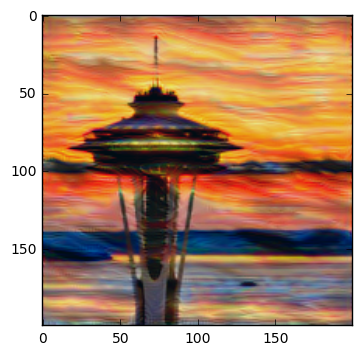

In [10]:
# utility to convert a vector to an image
def vec2img(x):
    d = np.round(np.sqrt(x.size / 3)).astype('i')
    return np.reshape(x.astype(np.float32),(3,d,d))

# utility to convert an image to a vector
def img2vec(img):
    return img.flatten().astype(np.float64)

# utility to compute the value and the gradient of f at a particular place defined by binding
def value_and_grads(f, binding):
    if len(f.outputs) != 1:
        raise InvalidArgumentException('function must return a single tensor')
    df, valdict = f.forward(binding, [f.output], set([f.output]))
    value = list(valdict.values())[0]
    grads = f.backward(df, {f.output: np.ones_like(value)}, set(binding.keys()))
    return value, grads

# setting up our objective function
def objfun(x,loss):
    y = vec2img(x)
    v, g = value_and_grads(loss, {loss.arguments[0]:[[y]]})
    v = np.reshape(v,(1,))
    g = img2vec(list(g.values())[0])
    return v, g

# the actual optimization procedure
def optimize(loss,x0,inner,outer):
    bounds = [(-np.min(SHIFT),255-np.max(SHIFT))]*x0.size
    for i in range(outer):
        s = opt.minimize(objfun, img2vec(x0), args=(loss,), method='L-BFGS-B', bounds=bounds, options={'maxiter':inner}, jac=True)
        print("objective : %s\n"%(s.fun[0]))
        x0 = vec2img(s.x)
        path = "%s_%s_%d.jpg"%(style_path,content_path,i)
        save_image(x0,path)
    return x0

np.random.seed(98052)
#x0 = np.random.randn(3,SIZE,SIZE).astype(np.float32)
x0 = content
xstar=optimize(loss, x0, inner, outer)
plt.imshow(np.asarray(np.transpose(xstar+SHIFT,(1,2,0)),dtype=np.uint8))